In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
from pathlib import Path
import sys
import glob
from os.path import join
os.environ['USE_PYGEOS'] = '0'
import geopandas as gpd
import pandas as pd
import numpy as np
import rasterio 
import matplotlib.pyplot as plt
import rasterio.plot
import rasterio.mask
from rasterio.crs import CRS

from util.files import *
from util.const import *
from util.ddfs import *

In [3]:
# FIPS will be passed in as an argument, one day...
FIPS = '34007'
# STATE ABBR and NATION will be derived from FIPS, one day...
STATEABBR = 'NJ'
NATION = 'US'

# Load data

In [4]:
# Load tabular data
# Start with just Mid and naccs
SCENARIO = 'Mid'
DDF_TYPE = 'naccs'

ens_filename = 'ensemble_' + SCENARIO + '.pqt'
ens_df = pd.read_parquet(join(FO, ens_filename))

opt_elev_filename = 'ens_opt_elev_' + DDF_TYPE + '_' + SCENARIO + '.pqt'
opt_elev_df = pd.read_parquet(join(EXP_DIR_I, FIPS, opt_elev_filename))

In [5]:
# Load geospatial data
fz_geo = gpd.read_file(join(POL_DIR_I, FIPS, "fld_zones.gpkg"))
clip_geo = gpd.read_file(join(REF_DIR_I, FIPS, "clip.gpkg"))
tract_geo = gpd.read_file(join(REF_DIR_I, FIPS, "tract.gpkg"))
bg_geo = gpd.read_file(join(REF_DIR_I, FIPS, "bg.gpkg"))
nsi_geo = gpd.read_file(join(EXP_DIR_I, FIPS, "nsi_sf.gpkg"))

# including vulnerability data
lmi = gpd.read_file(join(VULN_DIR_I, 'social', FIPS, 'lmi.gpkg'))
ovb = gpd.read_file(join(VULN_DIR_I, 'social', FIPS, 'ovb.gpkg'))
cejst = gpd.read_file(join(VULN_DIR_I, 'social', FIPS, 'cejst.gpkg'))
sovi = gpd.read_file(join(VULN_DIR_I, 'social', FIPS, 'sovi.gpkg'))

In [6]:
# Load raster data
# It would be interesting to show a few of the depth grids
# for the purposes of showing where flooding is occuring w/r/t
# the SFHA and water bodies
# Also, nice to show how these relate to ensemble eal means
# and later on, which houses get funded for how much elevation

# Want to load the Mid, 500 depth grid
mid_500_d = read_dg('500', 'Combination_Rain_WL_Mid')
# Want to load the Mid, 100 depth grid
mid_100_d = read_dg('100', 'Combination_Rain_WL_Mid')
# Want to load the Mid, 50 depth grid
mid_50_d = read_dg('050', 'Combination_Rain_WL_Mid')
# Want to load the Mid, 5 depth grid
mid_5_d = read_dg('005', 'Combination_Rain_WL_Mid')

# Want to load the Upper, 500 depth grid
up_500_d = read_dg('500', 'Combination_Rain_WL_Upper')
# Want to load the Upper, 100 depth grid
up_100_d = read_dg('100', 'Combination_Rain_WL_Upper')
# Want to load the Upper, 50 depth grid
up_50_d = read_dg('050', 'Combination_Rain_WL_Upper')
# Want to load the Upper, 5 depth grid
up_5_d = read_dg('005', 'Combination_Rain_WL_Upper')

In [14]:
# Read the boundary file
bnd_filep = join(FE, "haz", "GC_Catchments", "Gloucester_CatchmentsUTM.shp")
bnd_shp = gpd.read_file(bnd_filep)

In [59]:
# Read the dem & clip it to the boundary
# NOTE - big file was shared. Only rerun this code if you have to

# dem_filep = join(FE, "haz", "dem_subgrid_1m_nbd.asc")
# dem = rasterio.open(dem_filep)
# out_image, out_transform = rasterio.mask.mask(dem, 
#                                               bnd_shp['geometry'],
#                                               invert=False,
#                                               crop=True)
# out_meta = dem.meta

# out_meta.update({"driver": "GTiff",
#                  "height": out_image.shape[1],
#                  "width": out_image.shape[2],
#                  "crs": HAZ_CRS,
#                  "transform": out_transform})

# clip_filep = join(HAZ_DIR_I, 'dem_clip.tif')
# with rasterio.open(clip_filep, "w", **out_meta) as dest:
#     dest.write(out_image)

# Prepare data

In [7]:
# Need to put the optimal elevation heights in there
ens_df = ens_df.merge(opt_elev_df,
                      on=['fd_id', 'sow_ind'],
                      suffixes=['','_opt'])

# Get key metrics
# Get ens_agg for rel_eal, resid_rel_eal, & val_s metrics
ens_df['rel_eal'] = ens_df[DDF_TYPE + '_eal']/ens_df['val_s']
ens_agg = ens_df.groupby('fd_id')[['rel_eal', 
                                   'resid_rel_eal',
                                   'val_s']].mean().reset_index()

# We need to merge ens_agg with nsi_geo for plotting
ens_agg_plot = nsi_geo.merge(ens_agg,
                             how='inner',
                             on='fd_id')

In [8]:
# # Below is processing that will be helpful for our plots
# # We want to evaluate eal across scenarios
# for scen in ['Lower', 'Mid', 'Upper']:
#     # Column names that vary with scenario
#     rel_eal_col = 'rel_eal_' + scen
#     eal_col = 'eal_' + scen
#     eal_ens_col = 'eal_ens_mean_' + scen
#     rel_eal_ens_col = 'rel_eal_ens_mean_' + scen
#     eal_ens_std_col = 'eal_ens_std_' + scen
#     rel_eal_ens_std_col = 'rel_eal_ens_std_' + scen
    
    
#     # We want eal and value ensemble means, as well as rel_eal
#     # which we need to compute first
#     ens_df[rel_eal_col] = ens_df[eal_col]/ens_df['val_s']
#     temp = ens_df.groupby('fd_id')[[eal_col, 'val_s', rel_eal_col]].mean().reset_index()
#     # We also should track the standard deviation around these values
#     temp2 = ens_df.groupby('fd_id')[[eal_col, 'val_s', rel_eal_col]].std().reset_index()
    
#     # Let's add the basement type back in
#     # You can only elevate homes without a basement
#     nsi_res['b_type'] = nsi_res['occtype'].str.split('-').str[1].str[2:]
    
#     # We want to link up the ensemble mean loss columns, and our
#     # val_s mean with our nsi_res geodataframe
#     eal_dict = dict(zip(temp['fd_id'], temp[eal_col]))
#     rel_eal_dict = dict(zip(temp['fd_id'], temp[rel_eal_col]))
#     val_dict = dict(zip(temp['fd_id'], temp['val_s']))
    
#     nsi_res[eal_ens_col] = nsi_res['fd_id'].map(eal_dict)
#     nsi_res[rel_eal_ens_col] = nsi_res['fd_id'].map(rel_eal_dict)
#     nsi_res['val_ens_mean'] = nsi_res['fd_id'].map(val_dict)
    
#     # As well as the standard deviations
#     eal_std_dict = dict(zip(temp['fd_id'], temp2[eal_col]))
#     rel_eal_std_dict = dict(zip(temp['fd_id'], temp2[rel_eal_col]))
#     val_std_dict = dict(zip(temp['fd_id'], temp2['val_s']))
    
#     nsi_res[eal_ens_std_col] = nsi_res['fd_id'].map(eal_std_dict)
#     nsi_res[rel_eal_ens_std_col] = nsi_res['fd_id'].map(rel_eal_std_dict)
#     nsi_res['val_ens_std'] = nsi_res['fd_id'].map(val_std_dict)
    
#     # Let's also add in the benchmark eal
#     eal_bench_dict = dict(zip(bench_df['fd_id'], bench_df['eal']))
#     nsi_res['eal_nounc'] = nsi_res['fd_id'].map(eal_bench_dict)
#     nsi_res['rel_eal_nounc'] = nsi_res['eal_nounc']/nsi_res['val_struct']

In [9]:
# Want to clip the raster file to GC boundary polygon
# Following https://rasterio.readthedocs.io/en/
# stable/topics/masking-by-shapefile.html
clip_ref = gpd.read_file(join(FI, 'ref', FIPS, 'clip.gpkg'))
clip_ref_t = clip_ref.to_crs(HAZ_CRS)

# Loop through the rasters we loaded in
# and save the clipped raster in interim/
prepare_saving(HAZ_DIR_I)
r_list = [mid_500_d, mid_100_d, mid_50_d, mid_5_d,
          up_500_d, up_100_d, up_50_d, up_5_d,]

r_fp_list = ['dg_500_Mid', 'dg_100_Mid', 'dg_50_Mid', 'dg_5_Mid',
             'dg_500_Upper', 'dg_100_Upper', 'dg_50_Upper', 'dg_5_Upper']

for i, r in enumerate(r_list):
    out_image, out_transform = rasterio.mask.mask(r, 
                                                  clip_ref_t['geometry'],
                                                  invert=False,
                                                  crop=True)
    out_meta = r.meta
    
    out_meta.update({"driver": "GTiff",
                     "height": out_image.shape[1],
                     "width": out_image.shape[2],
                     "transform": out_transform})

    clip_filep = join(HAZ_DIR_I, r_fp_list[i] + '.tif')
    with rasterio.open(clip_filep, "w", **out_meta) as dest:
        dest.write(out_image)

    print("Clipped and wrote file: " + r_fp_list[i])


Clipped and wrote file: dg_500_Mid
Clipped and wrote file: dg_100_Mid
Clipped and wrote file: dg_50_Mid
Clipped and wrote file: dg_5_Mid
Clipped and wrote file: dg_500_Upper
Clipped and wrote file: dg_100_Upper
Clipped and wrote file: dg_50_Upper
Clipped and wrote file: dg_5_Upper


In [10]:
# Read the new raster files
mid_500_d = rasterio.open(join(HAZ_DIR_I, 'dg_500_Mid.tif'))
mid_100_d = rasterio.open(join(HAZ_DIR_I, 'dg_100_Mid.tif'))
mid_50_d = rasterio.open(join(HAZ_DIR_I, 'dg_50_Mid.tif'))
mid_5_d = rasterio.open(join(HAZ_DIR_I, 'dg_5_Mid.tif'))
up_500_d = rasterio.open(join(HAZ_DIR_I, 'dg_500_Upper.tif'))
up_100_d = rasterio.open(join(HAZ_DIR_I, 'dg_100_Upper.tif'))
up_50_d = rasterio.open(join(HAZ_DIR_I, 'dg_50_Upper.tif'))
up_5_d = rasterio.open(join(HAZ_DIR_I, 'dg_5_Upper.tif'))

depth_dict = {'500_Mid': mid_500_d,
              '100_Mid': mid_100_d,
              '50_Mid': mid_50_d,
              '5_Mid': mid_5_d,
              '500_Upper': up_500_d,
              '100_Upper': up_100_d,
              '50_Upper': up_50_d,
              '5_Upper': up_5_d}

In [61]:
# Read the clipped dem
dem_clip = rasterio.open(join(HAZ_DIR_I, 'dem_clip.tif'))

# Fig S1 - Plot the worfklow

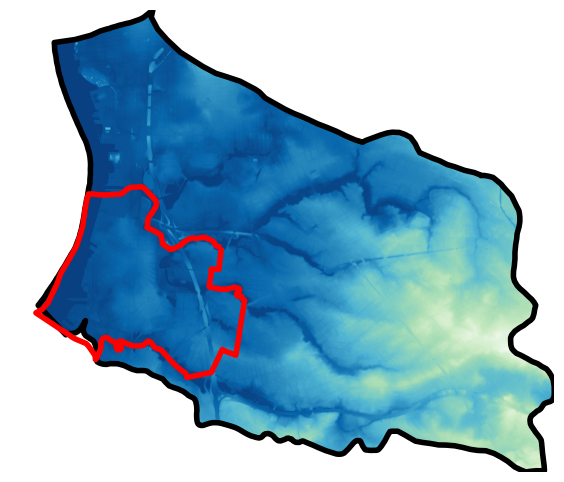

In [71]:
fig, ax = plt.subplots(figsize=(8, 6))

rasterio.plot.show(dem_clip, cmap='GnBu_r', ax=ax, vmin=0, vmax=40)

bnd_shp.plot(color='none', edgecolor='black', lw=4, ax=ax)
clip_ref_t.plot(color='none', edgecolor='red', lw=4, ax=ax)

ax.axis('off')

# Output figure
filename = 'workflow_dem_bounds.png'
fig.savefig(join(FIG_DIR, filename),
            dpi=600,
            bbox_inches='tight')

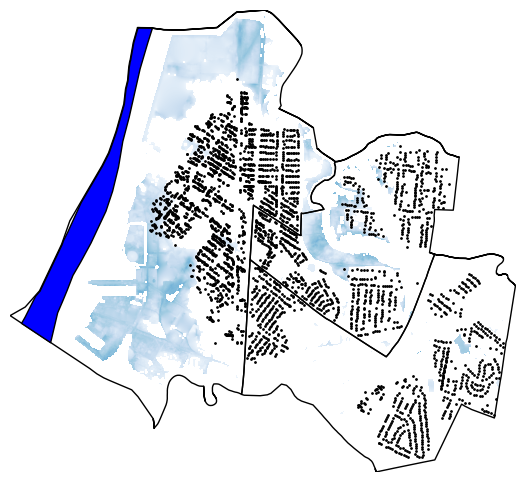

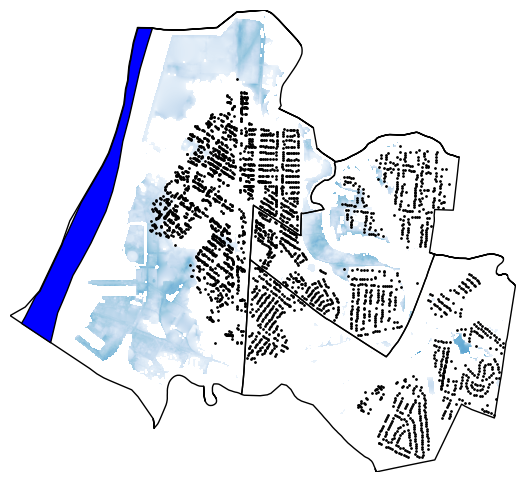

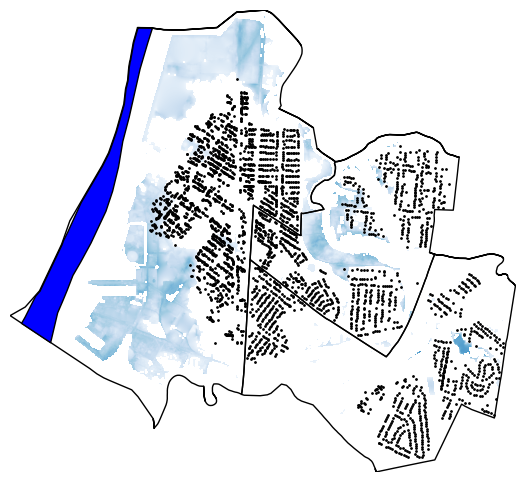

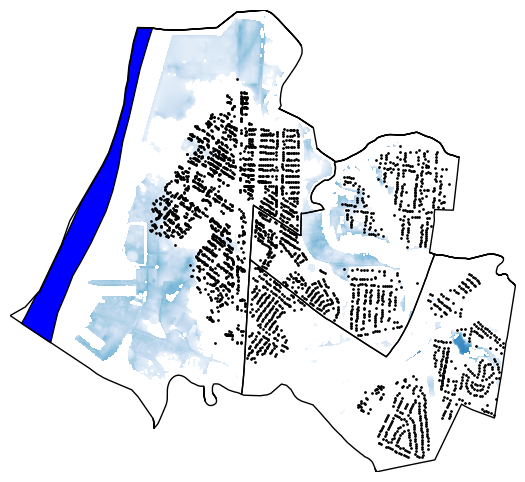

In [73]:
# Second piece - structure locations + hazard example

# Following other examples in the literature, these are pretty
# tiny figure inserts. So, don't use up space for legends
# This type of stuff is captured in the workflow text
# Let's plot the Mid depths
scen = 'Mid'

for ret_per in ['5', '50', '100', '500']:

    df_id = ret_per + '_' + scen
    depth_r = depth_dict[df_id]
    
    nsi_plot = nsi_geo.to_crs(HAZ_CRS)
    fz_plot = fz_geo.to_crs(HAZ_CRS)
    sfha_plot = fz_plot[fz_plot['fld_zone'].isin(['A', 'AE'])]
    open = fz_plot[fz_plot['fld_zone'] == 'OPEN WATER']
    t_plot = tract_geo.to_crs(HAZ_CRS)
    
    fig, ax = plt.subplots(figsize=(8, 6))
    nsi_plot.plot(markersize=1, color='black', ax=ax)
    t_plot.plot(ax=ax, color='none', edgecolor='black', lw=1)
    open.plot(ax=ax, color='blue', edgecolor='black')
    # use imshow so that we have something to map the colorbar to
    image_hidden = ax.imshow(depth_r.read(1),
                             cmap='Blues',
                             vmin=0,
                             vmax=4)
    rasterio.plot.show(depth_r, cmap='Blues', ax=ax, vmin=0, vmax=4)
    
    ax.axis('off')
    
    # Output figure
    filename = 'workflow_nsi_depth_' + scen + '_' + ret_per + '.png'
    fig.savefig(join(FIG_DIR, filename),
                dpi=600,
                bbox_inches='tight')

# Fig S2 - Show NSI fixed values

In [ ]:
# Sqft, basement & number of stories are taken as fixed
# Show these w/r/t SFHA